In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

---
STARTING CLEAN UP
1. prepare the  training points
   1. run 2D points with metedynamics
   2. project into the delNet.
   3. fill the rest 7D with Gaussian noise 
2. prepare the NN
   1. prepare the parameters
   2. define the NN: 3Layers, 10 nerouns/layer, 10D input
3. train the NN
   1. load 10D data
   2. traing NN, use mini batch for better results(optional) 
   3. virualization
4. Committor analysis
   1. Extract q=0.5 isocommittor contour
   2. Sample points from contour exp(-beta*V)
   3. Lift sampled Points to 10D
   4. stochastic simulation
   5. plot the committor prob hist

In [2]:
# ==============================================================================
# STAGE 1.1: GENERATE A LARGE 2D POINT CLOUD WITH METADYNAMICS
# ==============================================================================
print("--- Stage 1.1: Running 2D Metadynamics to Generate Point Cloud ---")

# --- Define the 2D Rugged Mueller Potential (for bias) ---
D_params = np.array([-200.0, -100.0, -170.0, 15.0])
a_params = np.array([-1.0, -1.0, -6.5, 0.7])
b_params = np.array([0.0, 0.0, 11.0, 0.6])
c_params = np.array([-10.0, -10.0, -6.5, 0.7])
X_params = np.array([1.0, 0.0, -0.5, -1.0])
Y_params = np.array([0.0, 0.5, 1.5, 1.0])
gamma, k = 9.0, 5.0

def grad_Vpot_2D(x):
    """Calculates the gradient of the 2D rugged Mueller potential."""
    grad = np.zeros(2)
    x1, x2 = x[0], x[1]
    for D, a, b, c, X, Y in zip(D_params, a_params, b_params, c_params, X_params, Y_params):
        dx1, dx2 = x1 - X, x2 - Y
        exp_term = D * np.exp(a*dx1**2 + b*dx1*dx2 + c*dx2**2)
        grad[0] += exp_term * (2 * a * dx1 + b * dx2)
        grad[1] += exp_term * (b * dx1 + 2 * c * dx2)
    common_factor = gamma * 2 * k * np.pi
    grad[0] += common_factor * np.cos(2*k*np.pi*x1) * np.sin(2*k*np.pi*x2)
    grad[1] += common_factor * np.sin(2*k*np.pi*x1) * np.cos(2*k*np.pi*x2)
    return grad

# --- Simulation Parameters ---
dt = 1e-5
beta_gen = 0.1 # Corresponds to T=10
# Use 2.1e5 points as the starting cloud as paper indicated
n_gaussians = 2100
steps_per_gaussian = 100
total_steps = n_gaussians * steps_per_gaussian

bias_height = 5.0
bias_width_sq = 0.05**2
bias_centers = []
x = np.array([-0.558, 1.441]) # Start in basin A
point_cloud_2d = np.zeros((total_steps, 2))
start_time = time.time()

print(f"Generating a 2D point cloud of {total_steps} points...")

for i in range(n_gaussians):
    bias_centers.append(x.copy())
    for j in range(steps_per_gaussian):
        idx = i * steps_per_gaussian + j
        force = -grad_Vpot_2D(x)
        
        # Add bias force from all previous centers
        diffs = x - np.array(bias_centers)
        exp_terms = np.exp(-np.sum(diffs**2, axis=1) / (2 * bias_width_sq))
        bias_force_contrib = (diffs / bias_width_sq) * (bias_height * exp_terms[:, None])
        force += np.sum(bias_force_contrib, axis=0)
        
        random_force = np.random.normal(0, 1, 2)
        x += force * dt + np.sqrt(2.0 * dt / beta_gen) * random_force
        point_cloud_2d[idx, :] = x
        
print(f"2D point cloud generation finished in {time.time() - start_time:.2f} seconds.")



--- Stage 1.1: Running 2D Metadynamics to Generate Point Cloud ---
Generating a 2D point cloud of 210000 points...
2D point cloud generation finished in 82.21 seconds.


In [3]:
# ==============================================================================
# STAGE 1.2: REFINE THE 2D POINT CLOUD INTO A 2D DELTA-NET
# ==============================================================================
print("\n--- Stage 1.2: Refining 2D Point Cloud into a 2D Delta-Net ---")

# Delta-net parameter from paper
delta = 0.005
delta_sq = delta**2
n_points = point_cloud_2d.shape[0]

# Labels: 0 = undecided, 1 = keep, 2 = discard
labels = np.zeros(n_points, dtype=np.int8)
keep_indices = []

start_time = time.time()
for i in range(n_points):
    if i % (n_points // 10) == 0: 
        print(f"  Processing point {i}/{n_points}...")
    
    if labels[i] != 0:
        continue
    
    labels[i] = 1
    keep_indices.append(i)
    
    # Use 2D distance
    diffs_2d = point_cloud_2d - point_cloud_2d[i]
    dists_sq_2d = np.sum(diffs_2d**2, axis=1)
    
    # Find indices of *undecided* points that are too close
    undecided_mask = (labels == 0)
    close_mask = (dists_sq_2d < delta_sq)
    
    # Update labels for undecided points that are too close
    labels[undecided_mask & close_mask] = 2

delta_net_2d = point_cloud_2d[keep_indices]
end_time = time.time()

print(f"Delta-net refinement finished in {end_time - start_time:.2f} seconds.")
print(f"2D Delta-net contains {delta_net_2d.shape[0]} points (Paper has 64882).")


--- Stage 1.2: Refining 2D Point Cloud into a 2D Delta-Net ---
  Processing point 0/210000...
  Processing point 21000/210000...
  Processing point 42000/210000...
  Processing point 63000/210000...
  Processing point 84000/210000...
  Processing point 105000/210000...
  Processing point 126000/210000...
  Processing point 147000/210000...
  Processing point 168000/210000...
  Processing point 189000/210000...
Delta-net refinement finished in 198.10 seconds.
2D Delta-net contains 53579 points (Paper has 64882).


In [4]:
# ==============================================================================
# STAGE 1.3: LIFT TO 10D AND FILTER
# ==============================================================================
print("\n--- STAGE 1.3: Lifting 2D-net to 10D and filtering ---")

# Lift to 10D by adding 8D Gaussian noise
beta = 0.1
sigma_quad = 0.05
sigma_G_sq = (sigma_quad**2) / (2 * beta)
sigma_G = np.sqrt(sigma_G_sq)

print(f"Sampling 8D coordinates from N(0, sigma_G^2 = {sigma_G_sq:.4f})")
n_delta_pts = delta_net_2d.shape[0]
points_8d = np.random.normal(loc=0.0, scale=sigma_G, size=(n_delta_pts, 8))

# Combine to form 10D training set
training_set_10d = np.concatenate((delta_net_2d, points_8d), axis=1)
print(f"Created 10D set with shape: {training_set_10d.shape}")

# Filter points in A and B
centerA = np.array([-0.558, 1.441])
centerB = np.array([0.623, 0.028])
radius = 0.1
radius_sq = radius**2

distA_sq = np.sum((training_set_10d[:, :2] - centerA)**2, axis=1)
distB_sq = np.sum((training_set_10d[:, :2] - centerB)**2, axis=1)

# Final datasets
trans_pts_np = training_set_10d[(distA_sq > radius_sq) & (distB_sq > radius_sq)]
ptsA_np = training_set_10d[distA_sq <= radius_sq]
ptsB_np = training_set_10d[distB_sq <= radius_sq]

print(f"\nGenerated {len(trans_pts_np)} final transition points.")
print(f"Generated {len(ptsA_np)} final boundary points for A.")
print(f"Generated {len(ptsB_np)} final boundary points for B.")

fname = "RuggedMueller_TrainingData.npz"
np.savez(fname, trans_pts=trans_pts_np, ptsA=ptsA_np, ptsB=ptsB_np)
print(f"\nSuccessfully saved all data to {fname}")


--- STAGE 1.3: Lifting 2D-net to 10D and filtering ---
Sampling 8D coordinates from N(0, sigma_G^2 = 0.0125)
Created 10D set with shape: (53579, 10)

Generated 52270 final transition points.
Generated 673 final boundary points for A.
Generated 636 final boundary points for B.

Successfully saved all data to RuggedMueller_TrainingData.npz


Successfully loaded 52270 training points from RuggedMueller_TrainingData.npz.


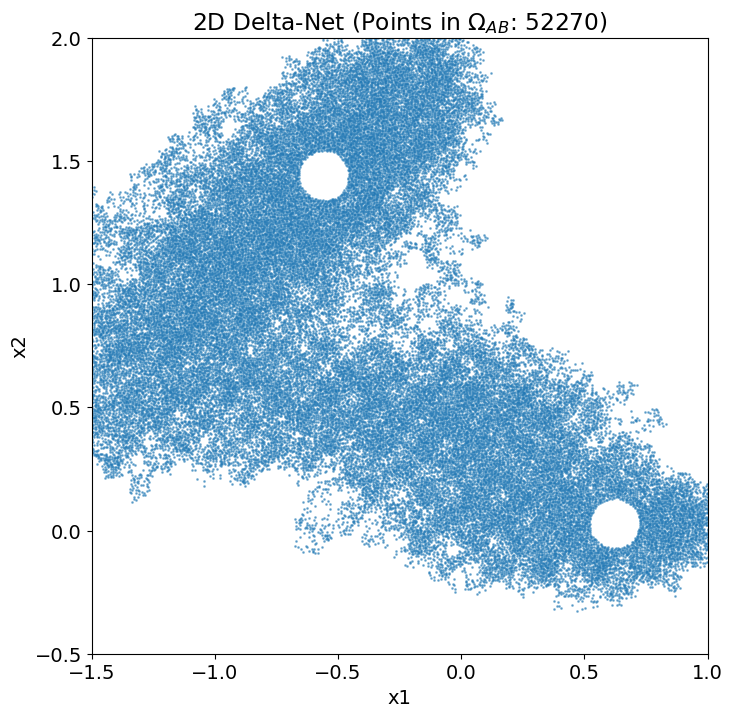

In [5]:
# Draw the points in 2D for visualization and confirmation
# --- Load the saved data ---
fname = "RuggedMueller_TrainingData.npz"
data_loaded = False
try:
    data = np.load(fname)
    # Load the transition points (the actual training set)
    xy_omegaAB = data['trans_pts']
    data_loaded = True
    print(f"Successfully loaded {xy_omegaAB.shape[0]} training points from {fname}.")
except FileNotFoundError:
    print(f"ERROR: Data file not found: {fname}")
except Exception as e:
    print(f"An error occurred: {e}")

# --- Plot the 2D projection ---
if data_loaded:
    plt.figure(figsize=(8, 8)) # Use a square figure for equal aspect
    plt.rcParams.update({'font.size': 14}) # Set font size

    # Create a scatter plot using only the x1 (column 0) and x2 (column 1)
    plt.scatter(xy_omegaAB[:, 0], xy_omegaAB[:, 1], s=1, alpha=0.5)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"2D Delta-Net (Points in $\Omega_{{AB}}$: {xy_omegaAB.shape[0]})")
    
    # Set plot limits and aspect ratio to match your example
    plt.xlim(-1.5, 1.0)
    plt.ylim(-0.5, 2.0)
    axes = plt.gca()
    axes.set_aspect('equal')

    plt.show()

### Notice that the training set exclude the A&B set to improve the accuracy

In [6]:
# ==============================================================================
# STAGE 2.1: PREPARE THE PARMETERS FOR 10D NEURAL NETWORK 
# ==============================================================================
print("\n--- STAGE 2.1: PREPARE THE PARMETERS FOR 10D NEURAL NETWORK  ---")

beta = torch.tensor(0.1) 
D_params_torch = torch.tensor([-200., -100., -170., 15.])
a_params_torch = torch.tensor([-1., -1., -6.5, 0.7])
b_params_torch = torch.tensor([0., 0., 11., 0.6])
c_params_torch = torch.tensor([-10., -10., -6.5, 0.7])
X_params_torch = torch.tensor([1., 0., -0.5, -1.])
Y_params_torch = torch.tensor([0., 0.5, 1.5, 1.])
sigma = 0.05
pi = torch.tensor(np.pi)

# Define 2D plot/sampling range
xmin, xmax = -1.5, 1.0
ymin, ymax = -0.5, 2.0

def Vpot_torch_2D_rugged(xy):
    """
    Calculates the 2D part of the rugged Mueller potential V_2D(x1, x2).
    Used for the re-weighted loss function.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    V0 = 0.0
    for i in range(4):
        dx1 = x1 - X_params_torch[i]
        dx2 = x2 - Y_params_torch[i]
        V0 += D_params_torch[i] * torch.exp(a_params_torch[i] * dx1**2 + b_params_torch[i] * dx1 * dx2 + c_params_torch[i] * dx2**2)
    V_perturb = gamma * torch.sin(2 * k * pi * x1) * torch.sin(2 * k * pi * x2)
    return V0 + V_perturb

def Vpot_numpy_2D_rugged(xy):
    """
    Calculates the 2D rugged Mueller potential V(x1, x2, 0, ..., 0).
    Used for plotting the energy landscape.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    V0 = 0.0
    for i in range(4):
        dx1 = x1 - X_params_torch.numpy()[i]
        dx2 = x2 - Y_params_torch.numpy()[i]
        V0 += D_params_torch.numpy()[i] * np.exp(a_params_torch.numpy()[i] * dx1**2 + b_params_torch.numpy()[i] * dx1 * dx2 + c_params_torch.numpy()[i] * dx2**2)
    V_perturb = gamma * np.sin(2 * k * pi.numpy() * x1) * np.sin(2 * k * pi.numpy() * x2)
    return V0 + V_perturb



--- STAGE 2.1: PREPARE THE PARMETERS FOR 10D NEURAL NETWORK  ---


In [7]:
# ==============================================================================
# STAGE 2.2: DEFINE THE 10D NEURAL NETWORK MODEL
# ==============================================================================
print("--- STAGE 2.2: Defining the 10D Neural Network Model ---")

class CommittorModelNN(torch.nn.Module):
    """
    Neural Network model based on paper.
    L=3 hidden layers, W=10 neurons, 10D input.
    """
    def __init__(self, in_size, hidden_size, out_size):
        super(CommittorModelNN, self).__init__()
        
        # 3 hidden layers, 10 neurons
        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.Tanh()
        self.linear3 = torch.nn.Linear(hidden_size, out_size)
        self.sigmoid = torch.nn.Sigmoid()
                                      
    def forward(self, x, a, b, ra, rb, ea, eb, fac):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.activation2(q)
        q = self.linear3(q)
        q = self.sigmoid(q) 
        
        sizex, nothing = x.shape
        
        # Indicator functions depend only on (x1, x2)
        aux0 = (((x[:, 0:2] - a[0:2]).pow(2)).sum(dim=1)).reshape(sizex, 1) - (ra + ea.clone().detach()).pow(2)
        aux1 = (((x[:, 0:2] - b[0:2]).pow(2)).sum(dim=1)).reshape(sizex, 1) - (rb + eb.clone().detach()).pow(2)
        
        chia = 0.5 - 0.5 * torch.tanh(fac * aux0)
        chib = 0.5 - 0.5 * torch.tanh(fac * aux1)   
        
        q = (1 - chia) * ((1 - chib) * q + chib)
        return q

# Define sets A and B
minimum_a_2d = np.array([-0.558, 1.441])
minimum_b_2d = np.array([0.623, 0.028])
minimum_a = np.pad(minimum_a_2d, (0, 8), 'constant')
minimum_b = np.pad(minimum_b_2d, (0, 8), 'constant')
a = torch.from_numpy(minimum_a).float()
b = torch.from_numpy(minimum_b).float()

ra = torch.tensor(0.1)
rb = torch.tensor(0.1)
fac = torch.tensor(100.)
ea = 2. / (ra * fac)
eb = 2. / (rb * fac)

# Define the dimensions for the neural network
in_size = 10      # 10D input
hidden_size = 10  # 10 Neurons per layer
out_size = 1      # Output size

# Instantiate the model
qmodel = CommittorModelNN(in_size, hidden_size, out_size)
print(qmodel)

--- STAGE 2.2: Defining the 10D Neural Network Model ---
CommittorModelNN(
  (linear0): Linear(in_features=10, out_features=10, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
# ==============================================================================
# STAGE 3.1: LOAD 10D TRAINING DATA
# ==============================================================================
print("\n--- STAGE 3.1: Loading 10D Training Data ---")

fname = "RuggedMueller_TrainingData.npz"
train_data = None
V_min_global = None

try:
    data = np.load(fname)
    # Load the transition points
    xy_omegaAB = data['trans_pts'].astype(np.float32)
    
    train_data = torch.from_numpy(xy_omegaAB)
    train_data.requires_grad_(True)
    
    size1, size2 = train_data.shape
    print(f"Loaded {size1} training points from {fname}.")

    # --- Find V_min for numerical stability ---
    print("Finding V_min for loss function stability...")
    # We only need the 2D coordinates for the V_2D part of the potential
    V_2D_all_pts = Vpot_torch_2D_rugged(train_data[:, 0:2])
    V_min_global = torch.min(V_2D_all_pts)
    print(f"Global V_min (on training set): {V_min_global.item():.4f}")

except FileNotFoundError:
    print(f"ERROR: Training data file not found: {fname}")
    print("Please run the data generation script first.")
except Exception as e:
    print(f"An error occurred: {e}")


--- STAGE 3.1: Loading 10D Training Data ---
Loaded 52270 training points from RuggedMueller_TrainingData.npz.
Finding V_min for loss function stability...
Global V_min (on training set): -147.2165


In [9]:
# ==============================================================================
# STAGE 3.2: TRAIN THE 10D MODEL
# ==============================================================================
print("\n--- STAGE 3.2: Training the 10D Model ---")

if train_data is not None:
    # add mini-batching to improve the efficiency and performance
    rhs = torch.zeros(size1,)
    train_dataset = TensorDataset(train_data, rhs)
    
    batch_size = 256 
    g = torch.Generator()
    g.manual_seed(seed)
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size, 
                                  shuffle=True,
                                  generator=g)
    
    # Optimizer with low learning rate
    optimizer1 = optim.Adam(qmodel.parameters(), lr=1e-4)
    # ---- Later results reduce the necessary epoch to 400, scheduler is not necessary here anymore -----
    # # Scheduler: reduce LR at 3000 and 4500 epochs
    # scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[3000, 4500], gamma=0.1)
    Nepochs = 400
    
    print("--- Starting Training (10D Model, Stable Loss, Explicit Grad) ---")
    start_time = time.time()

    for epoch in range(Nepochs):
        epoch_loss = 0.0
        num_batches = 0
        for X, y in train_dataloader:
            optimizer1.zero_grad()

            # Forward pass: q(x)
            q = qmodel(X, a, b, ra, rb, ea, eb, fac)

            # --- NUMERICALLY STABLE LOSS ---
            V_2D = Vpot_torch_2D_rugged(X[:, 0:2])

            # Autograd to calculate the gradient \nabla q (FIRST backward pass)
            derivQ = torch.autograd.grad(q, X, 
                                         grad_outputs=torch.ones_like(q),
                                         allow_unused=True,
                                         retain_graph=True, 
                                         create_graph=True)

            grad_norm_sq = torch.norm(derivQ[0], dim=1)**2
            reweight_factor = torch.exp(-beta * (V_2D - V_min_global))
            loss = torch.sum(grad_norm_sq * reweight_factor)
            # --- END STABLE LOSS ---

            # EXPLICIT GRAD
            all_params = list(qmodel.parameters())
            
            # Compute gradients w.r.t. parameters (SECOND backward pass)
            param_grads = torch.autograd.grad(loss, all_params, 
                                             allow_unused=True)
            
            # Manually set the gradients
            for param, grad in zip(all_params, param_grads):
                if grad is not None:
                    param.grad = grad
            # --- END EXPLICIT GRAD ---
            
            optimizer1.step()

            epoch_loss += loss.item()
            num_batches += 1

        # scheduler1.step()

        if epoch % 10 == 0 or epoch == Nepochs - 1:
            avg_loss = epoch_loss / num_batches
            if avg_loss < 2.5e-3:
                print(f"Early stopping at epoch {epoch} with Avg. Loss: {avg_loss:.4e}")
                break
            print(f"Epoch {epoch}/{Nepochs}, Avg. Loss: {avg_loss:.4e}")

    end_time = time.time()
    print(f"--- Training Finished in {end_time - start_time:.2f} seconds ---")
else:
    print("Skipping training because training data was not loaded.")


--- STAGE 3.2: Training the 10D Model ---
--- Starting Training (10D Model, Stable Loss, Explicit Grad) ---
Epoch 0/400, Avg. Loss: 1.7691e+01
Epoch 10/400, Avg. Loss: 2.2487e+00
Epoch 20/400, Avg. Loss: 1.1989e+00
Epoch 30/400, Avg. Loss: 1.4839e-01
Epoch 40/400, Avg. Loss: 7.8911e-02
Epoch 50/400, Avg. Loss: 6.1886e-02
Epoch 60/400, Avg. Loss: 5.0171e-02
Epoch 70/400, Avg. Loss: 2.3613e-02
Epoch 80/400, Avg. Loss: 4.7986e-03
Epoch 90/400, Avg. Loss: 3.5385e-03
Epoch 100/400, Avg. Loss: 3.3311e-03
Epoch 110/400, Avg. Loss: 3.1785e-03
Epoch 120/400, Avg. Loss: 3.0283e-03
Epoch 130/400, Avg. Loss: 2.8734e-03
Epoch 140/400, Avg. Loss: 2.7364e-03
Epoch 150/400, Avg. Loss: 2.6106e-03
Early stopping at epoch 160 with Avg. Loss: 2.4932e-03
--- Training Finished in 175.34 seconds ---



--- SATGE 3.3: Visualizing the Final Committor ---
Evaluating committor at training points...
Saved scatter plot to RuggedMueller_10D_Committor_Scatter.pdf


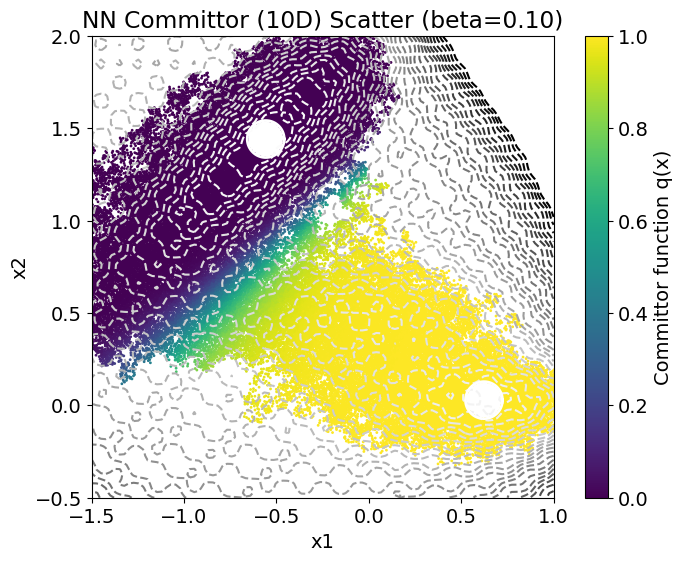

In [10]:
# ==============================================================================
# SATGE 3.3: VISUALIZE THE FINAL COMMITTOR
# ==============================================================================
print("\n--- SATGE 3.3: Visualizing the Final Committor ---")

if train_data is not None:
    # Get Committor Values at Training Points
    print("Evaluating committor at training points...")
    # Ensure train_data is the correct tensor
    # Detach from graph for evaluation
    q_at_training_pts = qmodel(train_data.requires_grad_(False), a, b, ra, rb, ea, eb, fac).detach().numpy()
    
    # Prepare for Plotting
    # 2D potential for contours
    nx, ny = (100, 100)
    nxy = nx * ny
    x1_plot = np.linspace(xmin, xmax, nx)
    y1_plot = np.linspace(ymin, ymax, ny)
    x_grid_plot, y_grid_plot = np.meshgrid(x1_plot, y1_plot)
    x_vec_plot = np.reshape(x_grid_plot, (nxy, 1))
    y_vec_plot = np.reshape(y_grid_plot, (nxy, 1))
    xy_plot_2d = np.concatenate((x_vec_plot, y_vec_plot), axis=1)
    v_plot = Vpot_numpy_2D_rugged(xy_plot_2d)
    v_grid_plot = np.reshape(v_plot, (nx, ny))

    # Plotting 
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    
    # Plot the potential contours in gray/white first (background)
    # Use dashed lines like the paper
    ls = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot, 
                     levels=np.linspace(np.min(v_plot), 250, 30), 
                     cmap="Greys", linestyles='dashed')
    
    # Plot the training points as a scatter plot
    # Use s=1 for small points, adjust alpha for density
    scatter = plt.scatter(xy_omegaAB[:, 0], xy_omegaAB[:, 1], 
                          c=q_at_training_pts, 
                          s=1,          # Small point size
                          cmap="viridis", # Color map
                          vmin=0, vmax=1) # Ensure color bar spans 0 to 1

    plt.colorbar(scatter, label="Committor function q(x)")
    
    # Plot boundaries of A and B (optional, but helpful)
    t = np.linspace(0, 2 * np.pi, 100)
    Abdry_x = minimum_a_2d[0] + ra.numpy() * np.cos(t)
    Abdry_y = minimum_a_2d[1] + ra.numpy() * np.sin(t)
    Bbdry_x = minimum_b_2d[0] + rb.numpy() * np.cos(t)
    Bbdry_y = minimum_b_2d[1] + rb.numpy() * np.sin(t)
    
    # Make A and B boundaries solid white circles for visibility
    plt.plot(Abdry_x, Abdry_y, linewidth=2, color='white', linestyle='solid')
    plt.plot(Bbdry_x, Bbdry_y, linewidth=2, color='white', linestyle='solid') # Or black if preferred
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"NN Committor (10D) Scatter (beta={beta.item():.2f})")
    axes = plt.gca()
    axes.set_aspect('equal')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    figname = f"RuggedMueller_10D_Committor_Scatter.pdf"
    plt.savefig(figname)
    print(f"Saved scatter plot to {figname}")
    plt.show()

else:
    print("Skipping visualization because model was not trained.")

### Compare with the paper figure 6(b), my result is not that clear on the left bottom corner. The potential reasons are
1. the dataset qulity is lower than original since I only catch the 53579 points < 64882 points in the original paper, which makes my NN is not as good as its. 
2. I ended the training process early from my expereience due to efficiency. I started late and want to finish early :). I won'r doult that if I run long enough and also adjust my hyperparameters will provide better results. 

p.s.: I didn't draw tghe A & B set data bc I'm lazy and also it's clearer when compare with FEM in figure 6(a) :p

#### To show my result also solid, I provide the countor pic here for reference. 

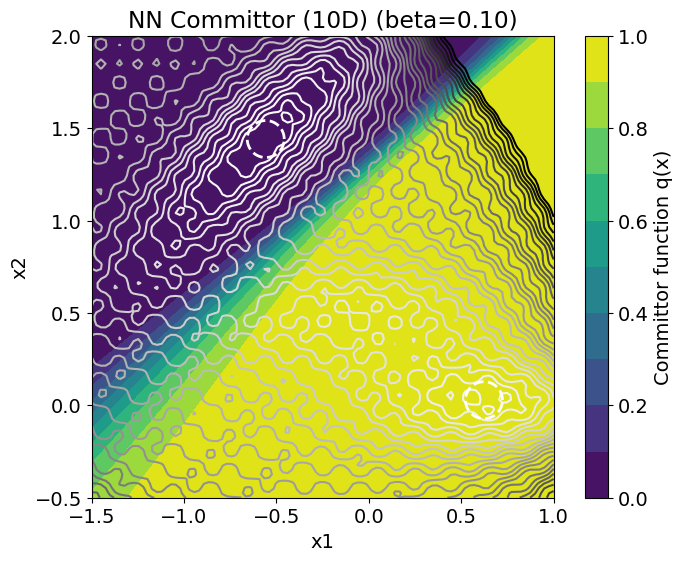

In [11]:
# --- Plotting ---
# --- Get Committor Values ---
# Pad 2D plot grid to 10D (with zeros)
xy_plot_10d = np.pad(xy_plot_2d, ((0, 0), (0, 8)), 'constant').astype(np.float32)
xy_plot_torch = torch.from_numpy(xy_plot_10d)

# Get committor values from the trained 10D model
q_plot_data = qmodel(xy_plot_torch, a, b, ra, rb, ea, eb, fac).detach().numpy()
q_grid = np.reshape(q_plot_data, (nx, ny))

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Plot the potential contours in gray/white
ls = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot, levels=np.linspace(np.min(v_plot), 250, 30), cmap="Greys")

# Plot the committor function
plt.contourf(x_grid_plot, y_grid_plot, q_grid, levels=np.linspace(0, 1, 11), cmap="viridis")
plt.colorbar(label="Committor function q(x)", orientation="vertical")

# Plot boundaries of A and B
t = np.linspace(0, 2 * np.pi, 100)
Abdry_x = minimum_a_2d[0] + ra.numpy() * np.cos(t)
Abdry_y = minimum_a_2d[1] + ra.numpy() * np.sin(t)
Bbdry_x = minimum_b_2d[0] + rb.numpy() * np.cos(t)
Bbdry_y = minimum_b_2d[1] + rb.numpy() * np.sin(t)

plt.plot(Abdry_x, Abdry_y, linewidth=2, color='white', linestyle='dashed')
plt.plot(Bbdry_x, Bbdry_y, linewidth=2, color='white', linestyle='dashed')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title(f"NN Committor (10D) (beta={beta.item():.2f})")
axes = plt.gca()
axes.set_aspect('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# figname = f"RuggedMueller_10D_Committor_Final.pdf"
# plt.savefig(figname)
# print(f"Saved committor plot to {figname}")
plt.show()

--- STAGE 4.1: Extracting q=0.5 Isocommittor Contour ---
Extracted 176 vertices from the q=0.5 contour.


/var/folders/93/sb3q7jsn5yj28sq4l66p3mr00000gn/T/ipykernel_71866/3250395614.py:32: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for path in cs.collections[0].get_paths():


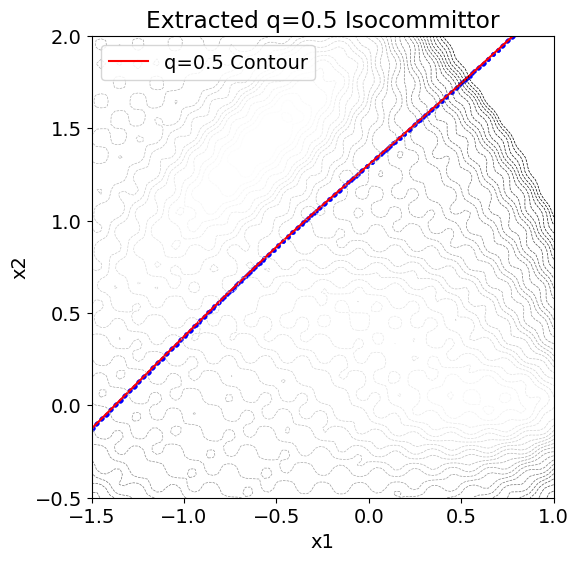

In [12]:
# Ensure qmodel is the trained 10D model from the previous steps
# Ensure Vpot_torch_2D_rugged and other parameters are defined

# ==============================================================================
# STAGE 4.1: EXTRACT q=0.5 ISOCOMMITTOR CONTOUR
# ==============================================================================
print("--- STAGE 4.1: Extracting q=0.5 Isocommittor Contour ---")

# Evaluate the model on the 2D plot grid (same grid as visualization)
xy_vec_plot = np.stack((x_grid_plot.flatten(), y_grid_plot.flatten()), axis=-1).astype(np.float32)

# Find the contour at level 0.5
contour_level = 0.5
cs = plt.contour(x_grid_plot, y_grid_plot, q_grid, levels=[contour_level])
plt.close() # Close the dummy plot used for contour finding

# Extract vertices from the contour path
# Note: There might be multiple segments, we concatenate them
contour_vertices = []
for path in cs.collections[0].get_paths():
    contour_vertices.append(path.vertices)
if not contour_vertices:
    raise ValueError("Could not find the q=0.5 contour. Check model training or contour level.")
contour_vertices = np.concatenate(contour_vertices, axis=0)

print(f"Extracted {contour_vertices.shape[0]} vertices from the q=0.5 contour.")

# Plot the contour to verify
plt.figure(figsize=(8, 6))
plt.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'r-', label='q=0.5 Contour')
plt.scatter(contour_vertices[:, 0], contour_vertices[:, 1], s=5, c='blue')
v_plot = Vpot_numpy_2D_rugged(xy_vec_plot)
v_grid_plot = np.reshape(v_plot, (nx, ny))
ls_bg = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot,
                 levels=np.linspace(np.min(v_plot), 250, 30),
                 cmap="Greys", linestyles='dashed', linewidths=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Extracted q=0.5 Isocommittor")
axes = plt.gca()
axes.set_aspect('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()



--- STAGE 4.2: Sampling Points from Contour ---
Sampling N=100 points...
Sampled 100 points.


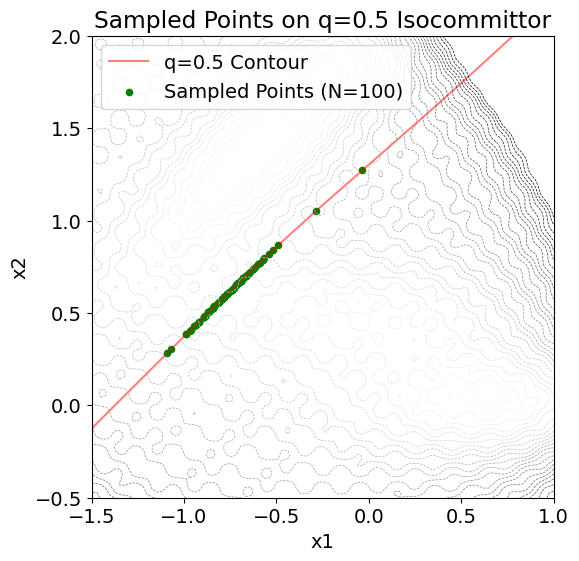

In [13]:
# ==============================================================================
# STAGE 4.2: SAMPLE POINTS FROM CONTOUR WEIGHTED BY exp(-beta*V)
# ==============================================================================
print("\n--- STAGE 4.2: Sampling Points from Contour ---")

N = 100 # Number of points to sample (adjust N=50 if slow)
print(f"Sampling N={N} points...")

# Evaluate 2D potential at contour vertices
contour_vertices_torch = torch.from_numpy(contour_vertices).float()
V_on_contour = Vpot_torch_2D_rugged(contour_vertices_torch)

# Calculate weights (use stable version relative to minimum on contour)
V_min_contour = torch.min(V_on_contour)
weights = torch.exp(-beta * (V_on_contour - V_min_contour)).numpy()

# Normalize weights to get probabilities
probabilities = weights / np.sum(weights)

# Sample indices based on probabilities
sampled_indices = np.random.choice(len(contour_vertices), size=N, p=probabilities, replace=True)
sampled_points_2d = contour_vertices[sampled_indices]

print(f"Sampled {sampled_points_2d.shape[0]} points.")

# Plot sampled points
plt.figure(figsize=(8, 6))
plt.plot(contour_vertices[:, 0], contour_vertices[:, 1], 'r-', alpha=0.5, label='q=0.5 Contour')
plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], s=20, c='green', label=f'Sampled Points (N={N})')
ls_bg = plt.contour(x_grid_plot, y_grid_plot, v_grid_plot,
                 levels=np.linspace(np.min(v_plot), 250, 30),
                 cmap="Greys", linestyles='dashed', linewidths=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Sampled Points on q=0.5 Isocommittor")
axes = plt.gca()
axes.set_aspect('equal')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

In [15]:
# ==============================================================================
# STAGE 4.3: LIFT SAMPLED POINTS TO 10D
# ==============================================================================
print("\n--- STAGE 4.3: Lifting Sampled Points to 10D ---")

# Calculate sigma_G for sampling 8D coordinates
sigma_quad = sigma # sigma=0.05 from parameters
beta_np = beta.numpy()
sigma_G_sq = (sigma_quad**2) / (2 * beta_np)
sigma_G = np.sqrt(sigma_G_sq)

print(f"Sampling 8D coordinates from N(0, sigma_G^2 = {sigma_G_sq:.4f})")
points_8d = np.random.normal(loc=0.0, scale=sigma_G, size=(N, 8))

# Combine to form 10D starting points
start_points_10d = np.concatenate((sampled_points_2d, points_8d), axis=1).astype(np.float32)
print(f"Created {start_points_10d.shape[0]} 10D starting points.")



--- STAGE 4.3: Lifting Sampled Points to 10D ---
Sampling 8D coordinates from N(0, sigma_G^2 = 0.0125)
Created 100 10D starting points.


In [16]:
# ==============================================================================
# STAGE 4.4: RUN STOCHASTIC TRAJECTORIES
# ==============================================================================
print("\n--- STAGE 4.4: Running Stochastic Trajectories ---")

M = 200 # Number of trajectories per starting point
dt_sim = 1e-4 # Simulation time step (can be larger than metadynamics dt)
max_steps = 500000 # Max steps per trajectory to prevent infinite loops

# Define 10D potential gradient (NumPy version needed for simulation)
D_params_np = D_params_torch.numpy()
a_params_np = a_params_torch.numpy()
b_params_np = b_params_torch.numpy()
c_params_np = c_params_torch.numpy()
X_params_np = X_params_torch.numpy()
Y_params_np = Y_params_torch.numpy()
pi_np = pi.numpy()

def grad_Vpot_10D_np(x):
    """Calculates the gradient of the 10D rugged Mueller potential."""
    grad = np.zeros_like(x)
    x1, x2 = x[0], x[1]
    for D, a, b, c, X, Y in zip(D_params_np, a_params_np, b_params_np, c_params_np, X_params_np, Y_params_np):
        dx1, dx2 = x1 - X, x2 - Y
        exp_term = D * np.exp(a*dx1**2 + b*dx1*dx2 + c*dx2**2)
        grad[0] += exp_term * (2 * a * dx1 + b * dx2)
        grad[1] += exp_term * (b * dx1 + 2 * c * dx2)
    common_factor = gamma * 2 * k * pi_np
    grad[0] += common_factor * np.cos(2*k*pi_np*x1) * np.sin(2*k*pi_np*x2)
    grad[1] += common_factor * np.sin(2*k*pi_np*x1) * np.cos(2*k*pi_np*x2)
    grad[2:] = (2.0 / sigma_quad**2) * x[2:]
    return grad

# Define A and B boundaries
centerA = minimum_a_2d # [-0.558, 1.441]
centerB = minimum_b_2d # [0.623, 0.028]
radius = ra.numpy() # 0.1
radius_sq = radius**2

results = [] # Store the outcome (0 for A, 1 for B) for each trajectory
committor_probabilities = np.zeros(N)

sqrt_2_dt_beta = np.sqrt(2.0 * dt_sim / beta_np)

start_time_sim = time.time()
print(f"Running M={M} trajectories for each of N={N} starting points...")

for i in range(N):
    if i % (N // 10) == 0 and i > 0:
        elapsed = time.time() - start_time_sim
        print(f"  Processed {i}/{N} starting points... (elapsed {elapsed:.1f}s)")
        
    hits_B = 0
    start_point = start_points_10d[i]
    
    for j in range(M):
        x_current = start_point.copy()
        hit_boundary = False
        for step in range(max_steps):
            # Calculate 2D distances for boundary check
            distA_sq = np.sum((x_current[:2] - centerA)**2)
            distB_sq = np.sum((x_current[:2] - centerB)**2)
            
            # Check boundary conditions
            if distA_sq <= radius_sq:
                results.append(0) # Hit A
                hit_boundary = True
                break
            if distB_sq <= radius_sq:
                results.append(1) # Hit B
                hits_B += 1
                hit_boundary = True
                break
                
            # Euler-Maruyama step
            gradV = grad_Vpot_10D_np(x_current)
            dW = np.random.normal(0.0, 1.0, 10)
            x_current += -gradV * dt_sim + sqrt_2_dt_beta * dW
            
        if not hit_boundary:
            print(f"Warning: Trajectory {j} from point {i} exceeded max_steps without hitting A or B.")
            # Decide how to handle this - e.g., discard or assign based on nearest basin
            # For simplicity, we'll exclude it from the count for this point
            pass # Or handle differently

    # Calculate empirical committor probability for starting point i
    if M > 0: # Avoid division by zero if a point had issues
         committor_probabilities[i] = hits_B / M
    else:
         committor_probabilities[i] = np.nan # Mark as invalid

end_time_sim = time.time()
print(f"Simulations finished in {end_time_sim - start_time_sim:.2f} seconds.")


--- STAGE 4.4: Running Stochastic Trajectories ---
Running M=200 trajectories for each of N=100 starting points...
  Processed 10/100 starting points... (elapsed 46.3s)
  Processed 20/100 starting points... (elapsed 90.7s)
  Processed 30/100 starting points... (elapsed 134.1s)
  Processed 40/100 starting points... (elapsed 176.7s)
  Processed 50/100 starting points... (elapsed 221.9s)
  Processed 60/100 starting points... (elapsed 266.6s)
  Processed 70/100 starting points... (elapsed 307.3s)
  Processed 80/100 starting points... (elapsed 349.2s)
  Processed 90/100 starting points... (elapsed 394.0s)
Simulations finished in 440.42 seconds.



--- STAGE 4.5: Plotting Committor Probability Histogram ---


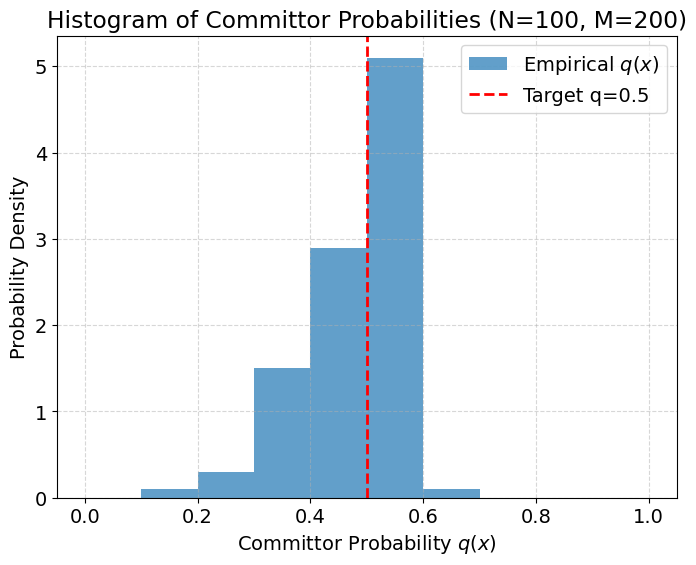

Mean empirical committor value on q=0.5 contour: 0.4769
Std deviation: 0.0897
YES: The histogram peak appears close to 0.5, suggesting the computed contour is reasonable


In [17]:
# ==============================================================================
# STAGE 4.5: CALCULATE AND PLOT HISTOGRAM
# ==============================================================================
print("\n--- STAGE 4.5: Plotting Committor Probability Histogram ---")

plt.figure(figsize=(8, 6))
plt.hist(committor_probabilities, bins=10, range=(0, 1), density=True, alpha=0.7, label='Empirical $q(x)$')
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=2, label='Target q=0.5')
plt.xlabel("Committor Probability $q(x)$")
plt.ylabel("Probability Density")
plt.title(f"Histogram of Committor Probabilities (N={N}, M={M})")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Calculate mean and std deviation
mean_q = np.nanmean(committor_probabilities)
std_q = np.nanstd(committor_probabilities)
print(f"Mean empirical committor value on q=0.5 contour: {mean_q:.4f}")
print(f"Std deviation: {std_q:.4f}")

if abs(mean_q - 0.5) < 0.1: # Check if mean is close to 0.5
    print("YES: The histogram peak appears close to 0.5, suggesting the computed contour is reasonable")
else:
    print("NO: The histogram peak is significantly different from 0.5, suggesting an issue with the computed committor")